## Transfer Learning

Up to this point all the analysis has been related to the Physionet Cardiology Challenge 2016 dataset, in this notebook we will put all the pieces together and try to solve the classification problem for the Kaggle dataset.

The same method in WB2 will used here. We will start by defining some methods to do feature extraction from the audio files preset in the Kaggle dataset. Then, we will use this to train a simple Feed Forward Network to have a result as a reference. Since more detail is provided in WB2, we will start with implementation.

In [78]:
import librosa
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
from librosa import display
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

## FFN

In [38]:
def extract_features_fnn(file_name):
    X, sr = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sr).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sr).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_file_fnn(filename):
    mfccs, chroma, mel, contrast, tonnetz = extract_features_fnn(filename)
    features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    return features

As we saw on WB1 the csv containing the labels for the Kaggle dataset has some row that do not have a label. The following method does the necessary cleaning and returns a dataframe with clean data.

In [80]:
def clean_dataset():
    df = pd.read_csv('data/kaggle/set_a.csv')
    df.drop(['sublabel'], axis=1, inplace=True)
    df.dropna(inplace=True)
    df['fname'] = df['fname'].apply(lambda fname: 'data/kaggle/' + fname)
    return df

df = clean_dataset()

Calculate features

In [48]:
df['features'] = df['fname'].apply(parse_file_fnn)

This time we a dealing with multiple labels and therefore we will need a LabelEncoder that comes from sklearn

In [49]:
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(df['label'])
encoded_Y = encoder.transform(df['label'])
y = np_utils.to_categorical(encoded_Y)

In [50]:
features = df["features"]
X = np.array(features.tolist())

## Training FFN

Split training and testing data

In [63]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, train_filenames, test_filenames = \
    train_test_split(X, y, df['fname'].values, test_size=0.30, random_state=42)

In [64]:
from keras.models import Sequential
from keras import layers

def create_ffn_model():
    model = Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape = (193,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [65]:
model = create_ffn_model()

In [66]:
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))

Train on 86 samples, validate on 38 samples
Epoch 1/40
86/86 [==============================] - 0s - loss: 10.8974 - acc: 0.1395 - val_loss: 8.1333 - val_acc: 0.3421
Epoch 2/40
86/86 [==============================] - 0s - loss: 9.2818 - acc: 0.2442 - val_loss: 7.2904 - val_acc: 0.2632
Epoch 3/40
86/86 [==============================] - 0s - loss: 8.4320 - acc: 0.2209 - val_loss: 6.9771 - val_acc: 0.2105
Epoch 4/40
86/86 [==============================] - 0s - loss: 7.8326 - acc: 0.2558 - val_loss: 6.9649 - val_acc: 0.2632
Epoch 5/40
86/86 [==============================] - 0s - loss: 7.3171 - acc: 0.2674 - val_loss: 6.6103 - val_acc: 0.2368
Epoch 6/40
86/86 [==============================] - 0s - loss: 6.5002 - acc: 0.2907 - val_loss: 5.4824 - val_acc: 0.2632
Epoch 7/40
86/86 [==============================] - 0s - loss: 5.9451 - acc: 0.3372 - val_loss: 5.6003 - val_acc: 0.3421
Epoch 8/40
86/86 [==============================] - 0s - loss: 5.8126 - acc: 0.3721 - val_loss: 4.9594 - val

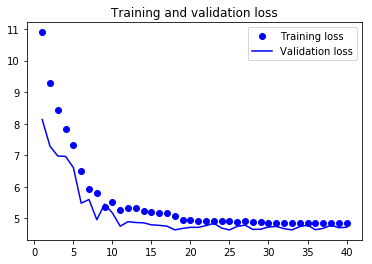

In [67]:
epochs = range(1, 41)
plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Results FFN

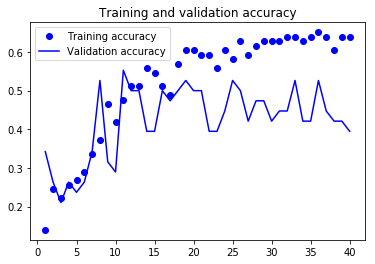

In [68]:
plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [69]:
def evaluate(model, x_test, y_test):
    y_prob = model.predict_proba(x_test, verbose=0)
    y_pred = y_prob.argmax(axis=-1)
    y_true = np.argmax(y_test, 1)
    
    # evaluate the model
    score, accuracy = model.evaluate(x_test, y_test, batch_size=32)
    print("\nAccuracy = {:.2f}".format(accuracy))

    # the F-score gives a similiar value to the accuracy score, but useful for cross-checking
    p = precision_score(y_true, y_pred, average='micro')
    r = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')
    print "Precision:", p
    print "Recall:", r
    print "F-Score:", f1
    print "Confusion Matrix:"
    print confusion_matrix(y_true, y_pred)
    
evaluate(model, x_test, y_test)

32/38 [========================>.....] - ETA: 0s
Accuracy = 0.39
Precision: 0.394736842105
Recall: 0.394736842105
F-Score: 0.394736842105
Confusion Matrix:
[[9 0 0 5]
 [0 1 0 6]
 [0 0 0 9]
 [1 2 0 5]]


## CNN

Now lets do the same but this time with method used for the CNN in WB3.

In [70]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

def extract_features_cnn(filename, bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    sound_clip,s = librosa.load(filename)        
    for (start,end) in windows(sound_clip,window_size):
        start = int(start)
        end = int(end)
        if(len(sound_clip[start:end]) == window_size):
            signal = sound_clip[start:end]
            melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
            logspec = librosa.logamplitude(melspec)
            logspec = logspec.T.flatten()[:, np.newaxis].T
            log_specgrams.append(logspec)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features)

In [101]:
def parse_files_cnn(df):
    save_path = os.path.join('data', 'kaggle', 'reduced_features')
    bands = 60
    frames = 41
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for index, row in df.iterrows():
        sound_clip,s = librosa.load(row['fname'])
        label = row['label']
        for (start,end) in windows(sound_clip,window_size):
            if(len(sound_clip[start:end]) == int(window_size)):
                signal = sound_clip[start:end]
                melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                logspec = librosa.logamplitude(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                log_specgrams.append(logspec)
                labels.append(label)
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    feature_file = os.path.join(save_path, 'cnn_x.npy')
    np.save(feature_file, np.array(features))    
    encoder = LabelEncoder()
    encoder.fit(labels)
    encoded_Y = encoder.transform(labels)
    y = np_utils.to_categorical(encoded_Y)
    label_file = os.path.join(save_path, 'cnn_y.npy')
    np.save(label_file, np.array(y))

In [102]:
df = clean_dataset()
parse_files_cnn(df)

In [104]:
npfiles = [('cnn_x.npy','cnn_y.npy')]

data_dir = os.path.join('data', 'kaggle', 'reduced_features')

def load_npfiles(npfiles):
    concatenate = False
    for x, y in npfiles:
        print("Adding X:", x)
        loaded_features = np.load(os.path.join(data_dir, x))
        print("Shape X:", loaded_features.shape)

        print("Adding y:", y)
        loaded_labels = np.load(os.path.join(data_dir, y))
        print("Shape Y:", loaded_labels.shape)

        if concatenate:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            concatenate = True
    return features, labels
    
X, y = load_npfiles(npfiles)

('Adding X:', 'cnn_x.npy')
('Shape X:', (1976, 60, 41, 2))
('Adding y:', 'cnn_y.npy')
('Shape Y:', (1976, 4))


## Training CNN

In [106]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [115]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
import keras.backend as K

def create_model_cnn(dropout_rate=0.5):
    frames = 41
    bands = 60
    feature_size = bands * frames
    num_channels = 2
    f_size = 1
    model = Sequential()
    model.add(Convolution2D(48, f_size, strides=f_size, kernel_initializer='normal', padding='same', input_shape=(bands, frames, num_channels)))
    model.add(Convolution2D(48, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(96, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Convolution2D(96, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [116]:
model = create_model_cnn()

In [117]:
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))

Train on 1383 samples, validate on 593 samples
Epoch 1/40
1383/1383 [==============================] - 14s - loss: 1.1817 - acc: 0.4736 - val_loss: 0.9332 - val_acc: 0.6459
Epoch 2/40
1383/1383 [==============================] - 13s - loss: 0.9075 - acc: 0.6161 - val_loss: 0.8161 - val_acc: 0.6560
Epoch 3/40
1383/1383 [==============================] - 13s - loss: 0.7674 - acc: 0.6500 - val_loss: 0.7265 - val_acc: 0.6880
Epoch 4/40
1383/1383 [==============================] - 13s - loss: 0.6761 - acc: 0.7180 - val_loss: 0.6802 - val_acc: 0.6981
Epoch 5/40
1383/1383 [==============================] - 13s - loss: 0.6465 - acc: 0.7231 - val_loss: 0.7025 - val_acc: 0.7032
Epoch 6/40
1383/1383 [==============================] - 13s - loss: 0.5970 - acc: 0.7542 - val_loss: 0.6725 - val_acc: 0.6880
Epoch 7/40
1383/1383 [==============================] - 13s - loss: 0.5754 - acc: 0.7542 - val_loss: 0.6860 - val_acc: 0.6863
Epoch 8/40
1383/1383 [==============================] - 13s - loss: 0.5

## Results CNN

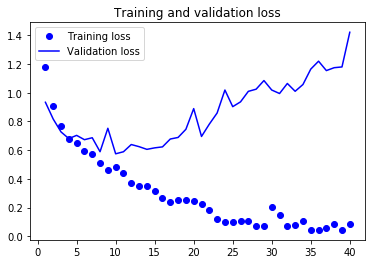

In [118]:
epochs = range(1, 41)
plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

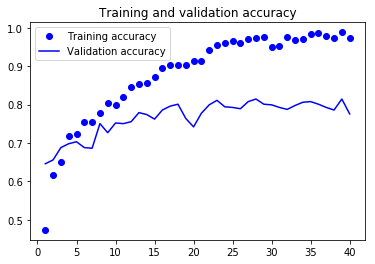

In [119]:
plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [120]:
evaluate(model, x_test, y_test)

576/593 [============================>.] - ETA: 0s
Accuracy = 0.78
Precision: 0.775716694772
Recall: 0.775716694772
F-Score: 0.775716694772
Confusion Matrix:
[[210   5   3   6]
 [  1  43   7  21]
 [  0   5 137   6]
 [  7  35  37  70]]


## Transfer Learning

In this part we will use the CNN that was trained in WB3. This CNN was trained with a bigger dataset and with a different set of labels. In this part we will take off the densly connected layer of model. Then we will freeze the convolutional layers so when the model trains with the new data the weights don't get modified. Finally we will add densly connected layers to clasify the four kind of labels present in the Kaggle dataset.

Since in WB3 we just saved the weights of the model we will need to create a model with the same structure as in WB3 and then load the corresponding weights.

In [163]:
def create_model(dropout_rate=0.5):
    frames = 41
    bands = 60
    feature_size = bands * frames
    num_channels = 2
    f_size = 1
    model = Sequential()
    model.add(Convolution2D(48, f_size, strides=f_size, kernel_initializer='normal', padding='same', input_shape=(bands, frames, num_channels)))
    model.add(Convolution2D(48, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(96, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Convolution2D(96, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [164]:
model = create_model()

In [165]:
model.load_weights('models/cnn_best.hdf5')

In [166]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 60, 41, 48)        144       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 41, 48)        2352      
_________________________________________________________________
activation_28 (Activation)   (None, 60, 41, 48)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 20, 48)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 20, 96)        4704      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 20, 96)        9312      
_________________________________________________________________
activation_29 (Activation)   (None, 30, 20, 96)        0         
__________

We will remove the orignal densly connected layers of the model.

In [167]:
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()

In [168]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 60, 41, 48)        144       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 41, 48)        2352      
_________________________________________________________________
activation_28 (Activation)   (None, 60, 41, 48)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 20, 48)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 20, 96)        4704      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 20, 96)        9312      
_________________________________________________________________
activation_29 (Activation)   (None, 30, 20, 96)        0         
__________

This will freeze the convolutional part of the model.

In [169]:
for layer in model.layers:
    layer.trainable = False

We will add different densly connected layers to be able to classify the four labels present in the dataset.

In [170]:
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Lets train the model

In [171]:
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))

Train on 1383 samples, validate on 593 samples
Epoch 1/40
1383/1383 [==============================] - 8s - loss: 1.3307 - acc: 0.4056 - val_loss: 1.2640 - val_acc: 0.5160
Epoch 2/40
1383/1383 [==============================] - 8s - loss: 1.1975 - acc: 0.5459 - val_loss: 1.1167 - val_acc: 0.5902
Epoch 3/40
1383/1383 [==============================] - 8s - loss: 1.0480 - acc: 0.6095 - val_loss: 0.9851 - val_acc: 0.6105
Epoch 4/40
1383/1383 [==============================] - 8s - loss: 0.9689 - acc: 0.6117 - val_loss: 0.9163 - val_acc: 0.6273
Epoch 5/40
1383/1383 [==============================] - 8s - loss: 0.8945 - acc: 0.6551 - val_loss: 0.8210 - val_acc: 0.6492
Epoch 6/40
1383/1383 [==============================] - 8s - loss: 0.8000 - acc: 0.6753 - val_loss: 0.7579 - val_acc: 0.6644
Epoch 7/40
1383/1383 [==============================] - 7s - loss: 0.7341 - acc: 0.6927 - val_loss: 0.7137 - val_acc: 0.6813
Epoch 8/40
1383/1383 [==============================] - 8s - loss: 0.6543 - ac

Lets evaluate results

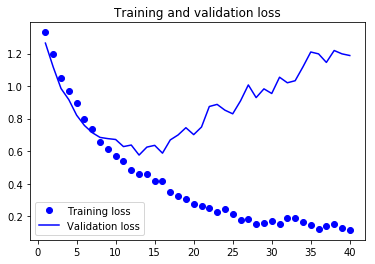

In [172]:
epochs = range(1, 41)
plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

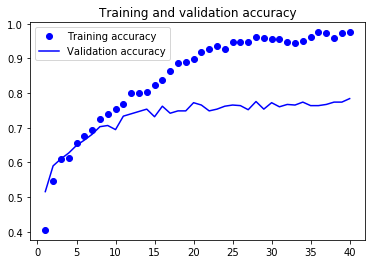

In [173]:
plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [174]:
evaluate(model, x_test, y_test)

576/593 [============================>.] - ETA: 0s
Accuracy = 0.78
Precision: 0.784148397976
Recall: 0.784148397976
F-Score: 0.784148397976
Confusion Matrix:
[[216   5   0   3]
 [  2  37   1  32]
 [  0   5 128  15]
 [  7  42  16  84]]
